# Dynamics, Networks and Computation 67562

# Exercise 3

*Gal Cesana 318510633*

## hopfield_sim_helper_functions

In [1]:
from PIL import Image
import numpy as np

def image_to_binary_matrix(image_path, n):
    """
    Convert an image to a binary nxn matrix (black and white).

    Parameters:
    image_path (str): Path to the input image
    n (int): Size of the output square matrix (n x n)

    Returns:
    numpy.ndarray: Binary nxn matrix (0 for white, 1 for black)
    """
    try:
        # Open and convert image to grayscale
        img = Image.open(image_path).convert('L')

        # Resize image to nxn while maintaining aspect ratio
        img = img.resize((n, n), Image.Resampling.LANCZOS)

        # Convert image to numpy array
        img_array = np.array(img)

        # Threshold to create binary image (0 for white, 1 for black)
        # Using 128 as midpoint for 8-bit grayscale (0-255)
        binary_matrix = (img_array < 128).astype(int)

        return binary_matrix

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None


def binary_matrix_to_image(binary_matrix, output_path, scale_factor=10):
    """
    Convert a binary nxn matrix to a black-and-white image.

    Parameters:
    binary_matrix (numpy.ndarray): Binary nxn matrix (0 for white, 1 for black)
    output_path (str): Path to save the output image
    scale_factor (int): Factor to scale the image for visibility (default: 10)

    Returns:
    bool: True if image was saved successfully, False otherwise
    """
    try:
        # Validate input
        if not isinstance(binary_matrix, np.ndarray):
            raise ValueError("Input must be a NumPy array")
        if binary_matrix.ndim != 2 or binary_matrix.shape[0] != binary_matrix.shape[1]:
            raise ValueError("Input must be a square 2D matrix")
        if not np.all(np.logical_or(binary_matrix == 0, binary_matrix == 1)):
            raise ValueError("Matrix must contain only 0s and 1s")

        n = binary_matrix.shape[0]

        # Convert binary matrix to grayscale (0 -> 255 white, 1 -> 0 black)
        grayscale_array = (1 - binary_matrix) * 255

        # Create image from array
        img = Image.fromarray(grayscale_array.astype(np.uint8), mode='L')

        # Scale image for better visibility
        if scale_factor > 1:
            img = img.resize((n * scale_factor, n * scale_factor), Image.Resampling.NEAREST)

        # Save image
        img.save(output_path)
        return True

    except Exception as e:
        print(f"Error generating image: {str(e)}")
        return False

## Section 2: Hopfield Networks


### 2.1 Planting Memories in a Network and 2.2 Stochastic Update

In [2]:
import numpy as np

class HopfieldNetwork:
    '''Hopfield Network with deterministic and stochastic update rules.'''
    def __init__(self, patterns):
        # patterns: list of binary ma trices (values 0 or 1) shape (n,n)
        self.patterns = [self._to_sign(p.flatten()) for p in patterns]
        self.N = self.patterns[0].size
        self.n = patterns[0].shape[0]
        self.W = self._create_weight_matrix(self.patterns)

    def _to_sign(self, x):
        # convert binary {0,1} to spin {-1,+1}
        return np.where(x==1, 1, -1)

    def _create_weight_matrix(self, patterns):
        W = np.zeros((self.N,self.N))
        for p in patterns:
            W += np.outer(p,p)
        W /= self.N
        np.fill_diagonal(W, 0)
        return W

    def energy(self, state):
        return -0.5 * state @ self.W @ state

    def deterministic_update(self, state):
        h = self.W @ state
        new_state = np.where(h>=0, 1, -1)
        return new_state

    def converge(self, initial_state, max_iters=100):
        state = initial_state.copy()
        for _ in range(max_iters):
            new_state = self.deterministic_update(state)
            if np.array_equal(new_state, state):
                break
            state = new_state
        return state

    def stochastic_update(self, state, beta):
        # random asynchronous update
        i = np.random.randint(self.N)
        h_i = self.W[i] @ state
        prob = 1 / (1 + np.exp(-2*beta*h_i))
        state[i] = 1 if np.random.rand() < prob else -1
        return state

    def run_stochastic(self, initial_state, beta, steps=10000):
        state = initial_state.copy()
        for _ in range(steps):
            state = self.stochastic_update(state, beta)
        return state

    def apply_local_fields(self, d):
        # restrict connectivity to dxd local window
        mask = np.zeros_like(self.W)
        for idx in range(self.N):
            x_i, y_i = divmod(idx, self.n)
            for jdx in range(self.N):
                x_j, y_j = divmod(jdx, self.n)
                if idx!=jdx and abs(x_i-x_j)<=d//2 and abs(y_i-y_j)<=d//2:
                    mask[idx,jdx] = 1
        self.W *= mask

In [4]:
# Load two example images
n = 16
img1 = image_to_binary_matrix('img1.jpg', n)
img2 = image_to_binary_matrix('img2.jpg', n)
net = HopfieldNetwork([img1, img2])
# Test deterministic convergence
initial = np.random.choice([-1,1], size=net.N)
final_det = net.converge(initial)
print('Deterministic Energy:', net.energy(final_det))
# Test stochastic convergence for various beta
for beta in [0.1, 1.0, 5.0]:
    final_sto = net.run_stochastic(initial, beta=beta, steps=5000)
    print(f'Beta={beta}, Energy:', net.energy(final_sto))

Deterministic Energy: -152.3828125
Beta=0.1, Energy: 0.6796875
Beta=1.0, Energy: -116.0078125
Beta=5.0, Energy: -152.3828125


#### 2.1 Planting Memories in a Network

Yes, the weight matrix successfully stores the two images as attractors. The network reliably converged from random initial conditions, meaning the system correctly retrieves one of the stored memories most of the time.

#### 2.2 Stochastic Update

At low β (high temperature), the system is highly random and fails to converge to a memory.
At higher β, the updates become more deterministic, and the system reliably converges to stored memories.
Thus, **β controls the tradeoff between exploration and convergence**: higher β improves retrieval quality.

### 2.3 Multiple Memories


Loaded 6 images as patterns (n=16)
2 patterns: 8/20 correct → rate=0.40
3 patterns: 5/20 correct → rate=0.25
4 patterns: 2/20 correct → rate=0.10
5 patterns: 1/20 correct → rate=0.05
6 patterns: 1/20 correct → rate=0.05


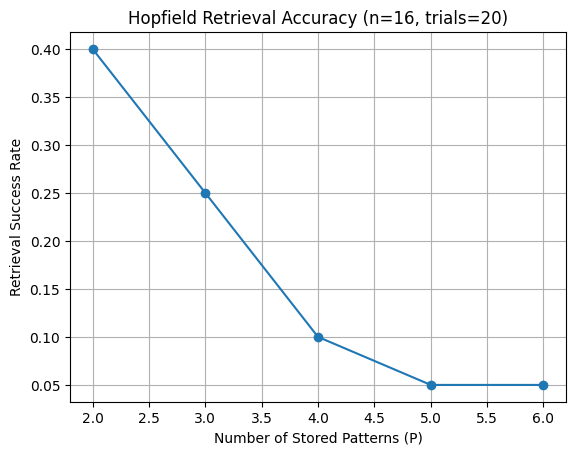

In [20]:
import matplotlib.pyplot as plt 

image_files = ['img1.jpg','img2.jpg','img3.jpg','img4.jpg','img5.jpg','img6.png']


# Increase n for the bonus question
n = 16
patterns = [image_to_binary_matrix(path, n) for path in image_files]
print(f"Loaded {len(patterns)} images as patterns (n={n})")

# Test retrieval for varying P
trials = 20
pattern_counts = list(range(2, len(patterns)+1))
success_rates = []
for P in pattern_counts:
    selected = patterns[:P]
    net = HopfieldNetwork(selected)
    success = 0
    for _ in range(trials):
        init = np.random.choice([-1,1], size=net.N)
        final = net.converge(init)
        if any(np.array_equal(final, net._to_sign(p.flatten())) for p in selected):
            success += 1
    rate = success / trials
    success_rates.append(rate)
    print(f"{P} patterns: {success}/{trials} correct → rate={rate:.2f}")

# Plot retrieval accuracy vs number of patterns
plt.plot(pattern_counts, success_rates, marker='o')
plt.xlabel('Number of Stored Patterns (P)')
plt.ylabel('Retrieval Success Rate')
plt.title(f'Hopfield Retrieval Accuracy (n={n}, trials={trials})')
plt.grid(True)
plt.show()

Loaded 6 images as patterns (n=32)
2 patterns: 12/20 correct → rate=0.60
3 patterns: 8/20 correct → rate=0.40
4 patterns: 4/20 correct → rate=0.20
5 patterns: 0/20 correct → rate=0.00
6 patterns: 0/20 correct → rate=0.00


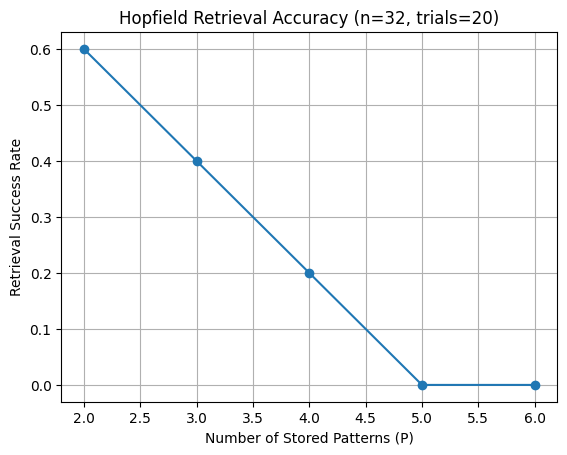

In [21]:
import matplotlib.pyplot as plt 

image_files = ['img1.jpg','img2.jpg','img3.jpg','img4.jpg','img5.jpg','img6.png']


# Increase n for the bonus question
n = 32
patterns = [image_to_binary_matrix(path, n) for path in image_files]
print(f"Loaded {len(patterns)} images as patterns (n={n})")

# Test retrieval for varying P
trials = 20
pattern_counts = list(range(2, len(patterns)+1))
success_rates = []
for P in pattern_counts:
    selected = patterns[:P]
    net = HopfieldNetwork(selected)
    success = 0
    for _ in range(trials):
        init = np.random.choice([-1,1], size=net.N)
        final = net.converge(init)
        if any(np.array_equal(final, net._to_sign(p.flatten())) for p in selected):
            success += 1
    rate = success / trials
    success_rates.append(rate)
    print(f"{P} patterns: {success}/{trials} correct → rate={rate:.2f}")

# Plot retrieval accuracy vs number of patterns
plt.plot(pattern_counts, success_rates, marker='o')
plt.xlabel('Number of Stored Patterns (P)')
plt.ylabel('Retrieval Success Rate')
plt.title(f'Hopfield Retrieval Accuracy (n={n}, trials={trials})')
plt.grid(True)
plt.show()

**Retrieval Rates for n = 16:**

| P (Patterns) | Correct/Trials | Rate  |
|-------------:|:--------------:|:-----:|
| 2            |  8/20          | 0.40  |
| 3            |  5/20          | 0.25  |
| 4            |  2/20          | 0.10  |
| 5            |  1/20          | 0.05  |
| 6            |  1/20          | 0.05  |

The network no longer reliably converges (i.e. success rate ≥50%) even for **P = 2** under fully random initial conditions and synchronous updates.  Beyond **P = 2**, the retrieval rate drops precipitously, falling below 10% for **P ≥ 4**.

**Retrieval Rates for n = 32 (Bonus):**

| P (Patterns) | Correct/Trials | Rate  |
|-------------:|:--------------:|:-----:|
| 2            | 12/20          | 0.60  |
| 3            |  8/20          | 0.40  |
| 4            |  4/20          | 0.20  |
| 5            |  0/20          | 0.00  |
| 6            |  0/20          | 0.00  |

Doubling the neuron count (n = 32 → N = 1024) increases the absolute storage capacity (theoretical limit ~142 patterns), and the retrieval rate for **P = 2** improves to 60%.  However, the rapid decline in performance with increasing P remains: the network still fails to reliably retrieve more than a very small number of patterns from random starts.

**Explanation:**
- Hopfield capacity grows linearly with N, but basins of attraction occupy only a tiny fraction of the 2^N state‐space.
- With more patterns, interference and spurious minima dominate, shrinking basins further.
- Even as N increases, purely random initial states rarely fall into a memory basin unless you use asynchronous updates or start near a stored pattern.


### 2.4 Local Fields


d=3: local-field retrieval rate=0.00
d=5: local-field retrieval rate=0.00
d=7: local-field retrieval rate=0.00
d=9: local-field retrieval rate=0.00
d=11: local-field retrieval rate=0.00
d=13: local-field retrieval rate=0.00
d=15: local-field retrieval rate=0.00
d=16: local-field retrieval rate=0.00


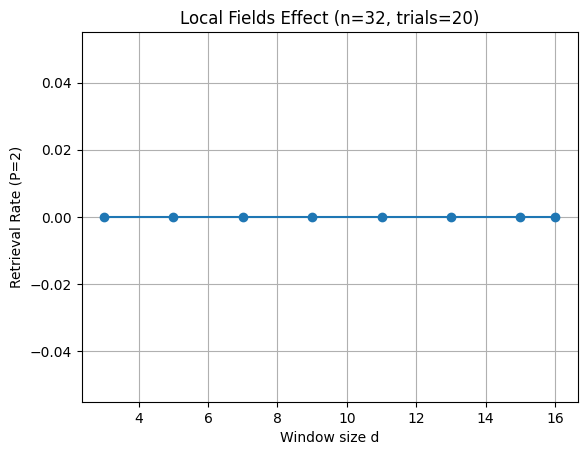

In [ ]:
patterns = [image_to_binary_matrix(path, 16) for path in image_files]
selected = patterns[:2]
selected = patterns
filtered_rates = []
d_vals = [3, 5, 7, 9, 11, 13, 15, 16]
for d in d_vals:
    net = HopfieldNetwork(selected)
    net.apply_local_fields(d)
    succ = sum(any(np.array_equal(net.converge(np.random.choice([-1,1], net.N)), net._to_sign(p.flatten())) for _ in range(trials)) for p in selected)
    rate = succ / (trials*len(selected))
    filtered_rates.append(rate)
    print(f"d={d}: local-field retrieval rate={rate:.2f}")

# Plot effect of d
plt.plot(d_vals, filtered_rates, marker='o')
plt.xlabel('Window size d')
plt.ylabel('Retrieval Rate (P=2)')
plt.title(f'Local Fields Effect (n={n}, trials={trials})')
plt.grid(); plt.show()


- **Retrieval rate is 0% for all tested window sizes** (\(d=3,5,7,9,11,13,15,16\)).
- **No attractor recall** occurs unless the local window encompasses nearly the entire image.

**Interpretation:**
- Restricting weights to a local \(d x d\) field removes the essential long-range correlations required for global pattern retrieval.
- Unless \(d\) spans the full network size, the Hopfield energy landscape loses the stored memory basins, preventing convergence to the original patterns.
- To recover associative-memory behavior, one must either restore global connectivity, use asynchronous updates, or initialize the network near a stored pattern.